# Class Challenge: Image Classification of COVID-19 X-rays
# Task 1 [Total points: 30]

## Setup

* This assignment involves the following packages: 'matplotlib', 'numpy', and 'sklearn'. 

* If you are using conda, use the following commands to install the above packages:<br>
```shell
conda install matplotlib
conda install numpy
conda install -c anaconda scikit-learn
```

* If you are using pip, use use the following commands to install the above packages: <br> 
```shell
pip install matplotlib
pip install numpy
pip install sklearn
```

## Data

Please download the data using the following link: [COVID-19](https://drive.google.com/file/d/1Y88tgqpQ1Pjko_7rntcPowOJs_QNOrJ-/view). 

* After downloading 'Covid_Data_GradientCrescent.zip', unzip the file and you should see the following data structure:


|--all<br>
|--------train<br>
|--------test<br>
|--two<br>
|--------train<br>
|--------test<br>


* Put the 'all' folder, the 'two' folder and this python notebook in the **same directory** so that the following code can correctly locate the data.  



## [20 points] Binary Classification: COVID-19 vs. Normal

In [1]:
import os

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
tf.__version__

'2.8.0'

#### Load Image Data

In [2]:
DATA_LIST = os.listdir('two/train')
DATASET_PATH  = 'two/train'
TEST_DIR =  'two/test'
IMAGE_SIZE    = (224, 224)
NUM_CLASSES   = len(DATA_LIST)
BATCH_SIZE    = 10  # try reducing batch size or freeze more layers if your GPU runs out of memory
NUM_EPOCHS    = 40
LEARNING_RATE = 0.0005 # start off with high rate first 0.001 and experiment with reducing it gradually 

#### Generate Training and Validation Batches

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=50,featurewise_center = True,
                                   featurewise_std_normalization = True,width_shift_range=0.2,
                                   height_shift_range=0.2,shear_range=0.25,zoom_range=0.1,
                                   zca_whitening = True,channel_shift_range = 20,
                                   horizontal_flip = True,vertical_flip = True,
                                   validation_split = 0.2,fill_mode='constant')

train_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "training",seed=42,
                                                  class_mode="binary")

valid_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "validation",seed=42,
                                                  class_mode="binary")

Found 104 images belonging to 2 classes.
Found 26 images belonging to 2 classes.


/Users/diana/opt/anaconda3/envs/SP22/lib/python3.10/site-packages/keras_preprocessing/image/image_data_generator.py:342: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  DATASET_PATH,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(224 , 224),
  batch_size= 10)

val_ds = tf.keras.utils.image_dataset_from_directory(
  DATASET_PATH,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(224, 224),
  batch_size=10)

test_ds = tf.keras.utils.image_dataset_from_directory(
  TEST_DIR,
  #validation_split=0.2,
  #ubset="validation",
  seed=123,
  image_size=(224, 224),
  batch_size=10)


class_names = train_ds.class_names
print(class_names)

Found 130 files belonging to 2 classes.
Using 104 files for training.
Found 130 files belonging to 2 classes.
Using 26 files for validation.
Found 18 files belonging to 2 classes.
['covid', 'normal']


2022-05-01 14:27:50.475934: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  TEST_DIR,
  #validation_split=0.2,
  #subset="training",
  seed=123,
  image_size=(224 , 224),
  batch_size= 10)

class_names = test_ds.class_names
print(class_names)

Found 18 files belonging to 2 classes.
['covid', 'normal']


ValueError: num must be 1 <= num <= 9, not 10

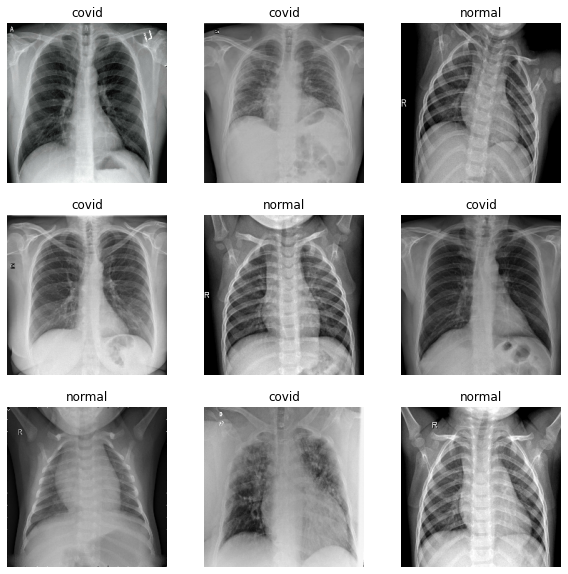

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(10, 224, 224, 3)
(10,)


In [9]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))


0.0 1.0


In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### [10 points] Build Model
Hint: Starting from a pre-trained model typically helps performance on a new task, e.g. starting with weights obtained by training on ImageNet. 

In [6]:
num_classes = 2


from keras.applications.vgg16 import VGG16
from tensorflow import keras 
from keras.layers import Dropout
from keras import layers

#model.compile(optimizer=SGD(lr=0.0001,momentum=0.9)), loss='catergorical_crossentropy')
data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"), layers.RandomRotation(0.1),]
)
#scale_layer - keras.layers.rescaling(scale=1/255)

base_model = keras.applications.VGG16(weights='imagenet', input_shape=(224, 224, 3), include_top=False)
base_model.trainable = False
inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs,outputs)
#model.build(input_shape=(None, 224, 224, 3))
model.summary()
#model = tf.keras.Sequential([
#    tf.keras.layers.Rescaling(1./255),
#    tf.keras.layers.Conv2D(32, 3, activation='relu'),
#    tf.keras.layers.MaxPooling2D(),
#    tf.keras.layers.Conv2D(32, 3, activation='relu'),
#    tf.keras.layers.MaxPooling2D(),    
#    tf.keras.layers.Conv2D(32, 3, activation='relu'),
#    tf.keras.layers.MaxPooling2D(),
#    tf.keras.layers.Conv2D(32, 3, activation='relu'),
#    tf.keras.layers.MaxPooling2D(),    
#    tf.keras.layers.Conv2D(64, 3, activation='relu'),
#    tf.keras.layers.MaxPooling2D(),
#    tf.keras.layers.Dropout(0.4),
#    tf.keras.layers.Flatten(),
#    tf.keras.layers.Dense(128, activation='relu'),
#    tf.keras.layers.Dense(num_classes,activation='softmax')
#])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_3 (Dense)             (None, 256)               6422784   
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 flatten_3 (Flatten)         (None, 256)               0         
                                                                 
 dropout_3 (Dropout)         (None, 256)               0   

#### [5 points] Train Model

In [13]:
valid_batches

In [96]:
results = []

In [12]:
#FIT MODEL
print(len(train_batches))
print(len(valid_batches))

STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size

#model = FullModel()
#model.build([(None, 224, 224, 1), (None, 10)])

#opt = tf.optimizers.Adam(lr=1e-3, decay=1e-3 / 200)
result = []
model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights = True)
EPOCHS = 10
#checkpoint_filepath = TEST_DIR
#cp_callback = tf.keras.callbacks.ModelCheckpoint(
#    filepath=checkpoint_filepath, 
#    verbose=1, 
#    save_weights_only=True,
#    save_freq=1*10
#)
#history = model.fit(
#    train_ds,
#    validation_data=val_ds,
#    epochs=40
#)
model.compile(optimizer=tf.keras.optimizers.Adam(0.0005), loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=[tf.keras.metrics.BinaryAccuracy()])

history = model.fit(train_batches, steps_per_epoch=len(train_batches), epochs=40, batch_size=10, validation_data=valid_batches, validation_steps=len(valid_batches),callbacks=callback)    
    #,
 #   callbacks = [cp_callback]

print(history.history.keys())


#model.save_weights('myModelweights.h5')

#raise NotImplementedError("Use the model.fit function to train your network")

11
3
Epoch 1/40
11/11 [==============================] - 56s 5s/step - loss: 0.4402 - binary_accuracy: 0.7885 - val_loss: 0.0991 - val_binary_accuracy: 0.9615
Epoch 2/40
11/11 [==============================] - 59s 5s/step - loss: 0.3642 - binary_accuracy: 0.8173 - val_loss: 0.0772 - val_binary_accuracy: 0.9615
Epoch 3/40
11/11 [==============================] - 57s 5s/step - loss: 0.3124 - binary_accuracy: 0.8462 - val_loss: 0.1961 - val_binary_accuracy: 0.9231
Epoch 4/40
11/11 [==============================] - 60s 6s/step - loss: 0.2742 - binary_accuracy: 0.8365 - val_loss: 0.1447 - val_binary_accuracy: 0.9231
Epoch 5/40
11/11 [==============================] - 60s 6s/step - loss: 0.3782 - binary_accuracy: 0.8269 - val_loss: 0.1113 - val_binary_accuracy: 1.0000
Epoch 6/40
11/11 [==============================] - 61s 6s/step - loss: 0.2574 - binary_accuracy: 0.9038 - val_loss: 0.0569 - val_binary_accuracy: 1.0000
Epoch 7/40
11/11 [==============================] - 64s 6s/step - loss:

KeyboardInterrupt: 

#### [5 points] Plot Accuracy and Loss During Training

In [11]:
import matplotlib.pyplot as plt

plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'], label='test_accuracy')
plt.ylim((0,1.1))
plt.title('model accuracy')
plt.ylabel('acurracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], label='test_loss')
plt.ylim((-0.1,1.1))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


#raise NotImplementedError("Plot the accuracy and the loss during training")

NameError: name 'history' is not defined

#### Plot Test Results

Found 18 images belonging to 2 classes.


/var/folders/2g/c1g3z17d3c914h50f_sxqw5m0000gp/T/ipykernel_70259/1882219165.py:7: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred = model.predict_generator(eval_generator,18,verbose=1)


18/18 [==============================] - 9s 474ms/step
covid/nejmoa2001191_f3-PA.jpeg


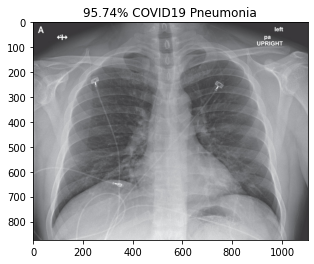

covid/nejmoa2001191_f4.jpeg


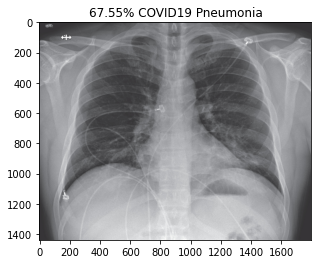

covid/nejmoa2001191_f5-PA.jpeg


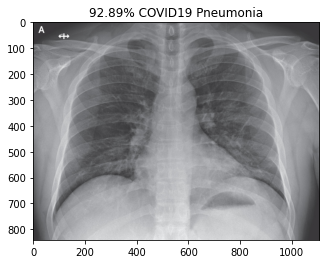

covid/radiol.2020200490.fig3.jpeg


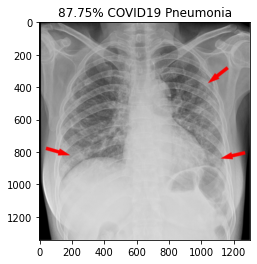

covid/ryct.2020200028.fig1a.jpeg


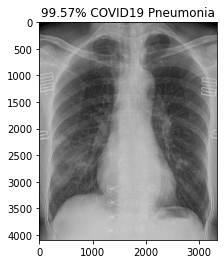

covid/ryct.2020200034.fig2.jpeg


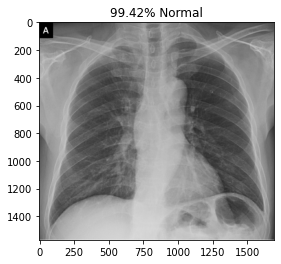

covid/ryct.2020200034.fig5-day0.jpeg


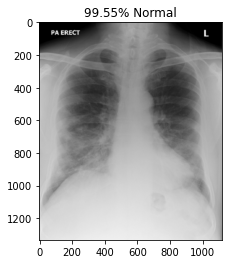

covid/ryct.2020200034.fig5-day4.jpeg


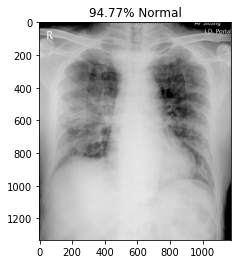

covid/ryct.2020200034.fig5-day7.jpeg


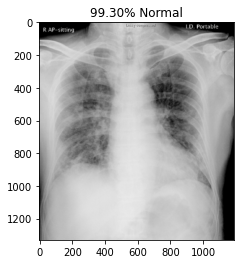

normal/NORMAL2-IM-1385-0001.jpeg


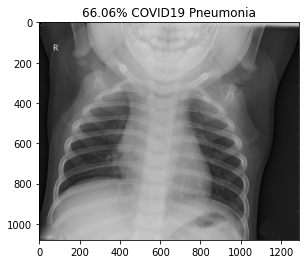

normal/NORMAL2-IM-1396-0001.jpeg


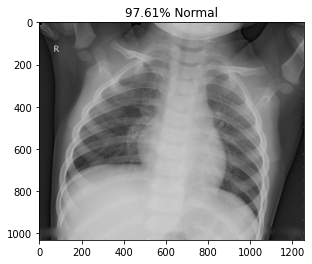

normal/NORMAL2-IM-1400-0001.jpeg


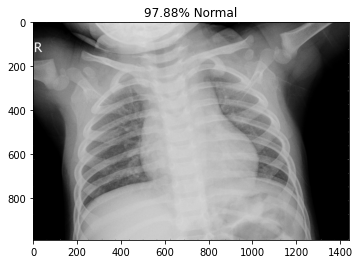

normal/NORMAL2-IM-1401-0001.jpeg


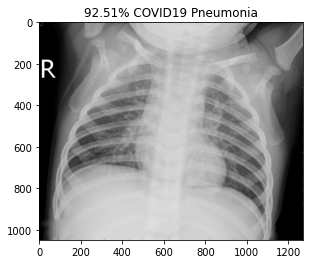

normal/NORMAL2-IM-1406-0001.jpeg


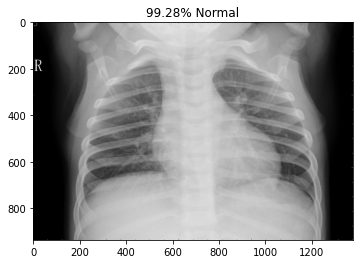

normal/NORMAL2-IM-1412-0001.jpeg


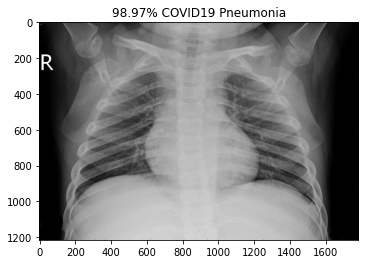

normal/NORMAL2-IM-1419-0001.jpeg


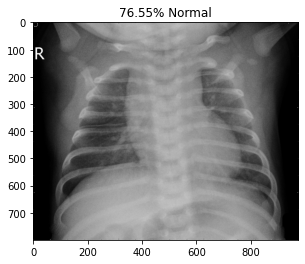

normal/NORMAL2-IM-1422-0001.jpeg


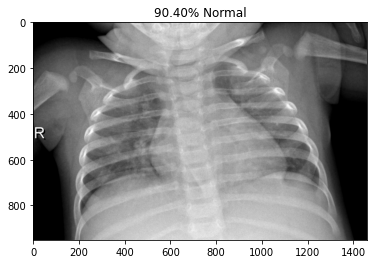

normal/NORMAL2-IM-1423-0001.jpeg


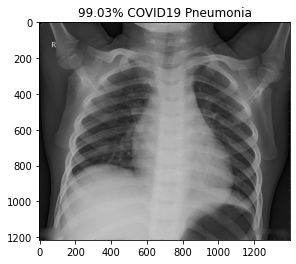

In [15]:
import matplotlib.image as mpimg

test_datagen = ImageDataGenerator(rescale=1. / 255)
eval_generator = test_datagen.flow_from_directory(TEST_DIR,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=True,seed=42,class_mode="binary")
eval_generator.reset()
pred = model.predict_generator(eval_generator,18,verbose=1)
for index, probability in enumerate(pred):
    image_path = TEST_DIR + "/" +eval_generator.filenames[index]
    image = mpimg.imread(image_path)
    if image.ndim < 3:
        image = np.reshape(image,(image.shape[0],image.shape[1],1))
        image = np.concatenate([image, image, image], 2)
#         print(image.shape)

    pixels = np.array(image)
    plt.imshow(pixels)
    
    print(eval_generator.filenames[index])
    if probability > 0.5:
        plt.title("%.2f" % (probability[0]*100) + "% Normal")
    else:
        plt.title("%.2f" % ((1-probability[0])*100) + "% COVID19 Pneumonia")
    plt.show()
    
x = model.evaluate_generator(eval_generator,steps = np.ceil(len(eval_generator)),
                           use_multiprocessing = False,verbose = 1,workers=1)
print('Test loss:' , x[0])
print('Test accuracy:',x[1])

## [10 points] TSNE Plot
t-Distributed Stochastic Neighbor Embedding (t-SNE) is a widely used technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. After training is complete, extract features from a specific deep layer of your choice, use t-SNE to reduce the dimensionality of your extracted features to 2 dimensions and plot the resulting 2D features.

Found 130 images belonging to 2 classes.


/Users/diana/opt/anaconda3/envs/SP22/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/diana/opt/anaconda3/envs/SP22/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 130 samples in 0.000s...
[t-SNE] Computed neighbors for 130 samples in 0.014s...
[t-SNE] Computed conditional probabilities for sample 130 / 130
[t-SNE] Mean sigma: 2.100454
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.204254
[t-SNE] KL divergence after 900 iterations: 0.092874


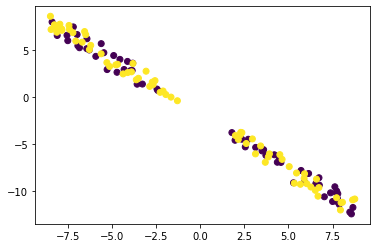

In [20]:
from sklearn.manifold import TSNE

intermediate_layer_model = keras.models.Model(inputs=model.input,
                                        outputs=model.get_layer('dense_1').output)
tsne_data_generator = test_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=True,seed=42,class_mode="binary")
intermediate_output = intermediate_layer_model.predict(tsne_data_generator)
tsne_em = TSNE(n_components=2, verbose =1).fit_transform(intermediate_output)

plt.scatter(tsne_em[:,0], tsne_em[:,1], c=tsne_data_generator.classes)
plt.show()

<!-- ## Task 2: COVID-19 vs Normal vs Tertiary Pneumonia (Bacterial and Viral) -->

<!-- #### Renew Training Batch and Validation Batch -->

<!-- #### Renew Model -->